In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

# S.10 추론

## S.10.1 Kolmogorov-Smirnov 검증
- 비모수 추정 방법(정규분포 따른다는 전제로 통계적 추정을 하지 않음)

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

In [3]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
#임의의 표본 data
xRdd = spark.sparkContext.parallelize([1.0, 2.0, 5.0, 4.0, 3.0, 3.3, 5.5])

kolmogorovSmirnovTest는 mllib 모듈을 사용한다. 검증하려는 분포의 문자열를 입력한다. 현재는 **정규분포 "norm"**만을 지원한다.

In [5]:
from pyspark.mllib.stat import Statistics

testResult = Statistics.kolmogorovSmirnovTest(xRdd, "norm") #norm: 정규분포

In [6]:
print(testResult)
#pValue가 매우 작은값이 나왔다!->귀무가설 기각: 정규분포를 따르지 않는다.

Kolmogorov-Smirnov test summary:
degrees of freedom = 0 
statistic = 0.841344746068543 
pValue = 5.06089025353873E-6 
Very strong presumption against null hypothesis: Sample follows theoretical distribution.


### scipy Kolmogorov-Smirnov

In [7]:
from scipy.stats import kstest

kstest([1.0, 2.0, 5.0, 4.0, 3.0, 3.3, 5.5], 'norm') #norm: 정규분포

KstestResult(statistic=0.8413447460685429, pvalue=5.060890253444183e-06)

In [8]:
#집단간의 차이도 볼 수 있다.
#p<0.005이므로 "집단간의 차이가 없다"라는 귀무가설 기각->집단간의 차이가 있다
kstest([1.0, 2.0, 5.0, 4.0, 3.0, 3.3, 5.5], [11.0, 12.0, 15.0, 14.0, 13.0, 13.3, 15.5])

KstestResult(statistic=1.0, pvalue=0.0005827505827505828)

In [9]:
# 두 집단간의 차이가 없다
kstest([1.0, 2.0, 5.0, 4.0, 3.0, 3.3, 5.5], [1.1, 2.1, 5.1, 4.1, 3.1, 3.4, 5.6], 'norm')

KstestResult(statistic=0.14285714285714285, pvalue=0.9999609537692629)

## S.10.2 ANOVA

- 그룹간 평균에 통계적으로 유의미한 차이가 있는가 판단하는 기법
- Spark에는 ANOVA 모듈이 없다.
- Python에서는 stats model을 사용한다.

#### 데이터
- Statesmodel에서 Moore 데이터를 가져오자.
- Moore는 파트너의 신분이 높거나 낮은 경우 그 결정에 얼마나 따르는지 보는 사회심리실험 데이터이다.


>partner.status 파트너의 신분 high, low  
>conformity conforming하는 회수 (전체 40회)  
>fcategory: F-Scale 구분 high, low, medium.  
>fscore: Authoritarianism 권위주의 점수

In [11]:
import statsmodels.api as sm

moore=sm.datasets.get_rdataset("Moore","carData")

In [13]:
type(moore)

statsmodels.datasets.utils.Dataset

`moore.` (하고 tab키누르면 함수들이 뜬다)

In [14]:
moore.data.head()

,partner.status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36


In [15]:
# 컬럼명 변경
moore.data.columns=['status','conformity', 'fcategory', 'fscore']
moore.data.columns

Index(['status', 'conformity', 'fcategory', 'fscore'], dtype='object')

In [16]:
moore.data.head()

,status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36


#### R 스타일 모델링
R 스타일에 따라 종속변수 fscore, 독립변수 status, fcategory로 모델링한다. 이때 명목변수는 C() 연산자를 사용한다.

In [17]:
from statsmodels.formula.api import ols
#fscore: 종속변수, status, fcategory: 독립변수
#독립변수 따라 종속변수가 결정되는 방식

formula='fscore~C(status)*C(fcategory)' #C: category
model=ols(formula, data=moore.data).fit() #ols: 최소자승법, moredata사용, fit():모델링 실행

#### ANOVA 적용
- 선형모델 ANOVA를 적용해 보자. 아래에서 fcategory의 PR이 0.05보다 적다. 
- **즉 fcategory high, low, medium의 그룹 간 유의미하게 평균의 차이가 있다는 의미이다.**

아래 표에서 과학적 표기를 이해해 보자. E+01은 소수점을 오른쪽으로 1칸 이동, E+00는 현재 그대로, E–01은 왼쪽으로 1칸 이동해서 읽으면 된다. 6.330623e-01은 0.6330623을 의미한다

In [21]:
from statsmodels.stats.anova import anova_lm

result = anova_lm(model)

In [22]:
result

,df,sum_sq,mean_sq,F,PR(>F)
C(status),1.0,7.932587,7.932587,0.231555,6.330623e-01
C(fcategory),2.0,7561.365635,3780.682818,110.359336,8.768957e-17
C(status):C(fcategory),2.0,29.086807,14.543403,0.424527,6.570656e-01
Residual,39.0,1336.059416,34.257934,NaN,NaN


p가 0.005보다 작은 경우: 유의미  
유의미한 차이가 있는 것 `fcategory`  ->다른건 봐봤자 의미가없다. 다른건 평균이나 그래프 안그림  

anova: sample 3개 이상, ks 2개

#### 평균
statsmodels에서 읽은 데이터는 moore.data하면 pandas의 DataFrame이다. 따라서 groupby() 명령어로 평균을 쉽게 구할 수 있다.
- 그림그리려면 pandas로

In [39]:
moorePd = moore.data

In [40]:
moorePd.groupby('fcategory').mean()
#conformity 신경안써도됨

,conformity,fscore
fcategory,,
high,12.266667,58.533333
low,11.733333,26.933333
medium,12.400000,43.866667


In [41]:
moorePd.groupby('fcategory')['fscore'].mean()

fcategory
high      58.533333
low       26.933333
medium    43.866667
Name: fscore, dtype: float64

#### 그래프

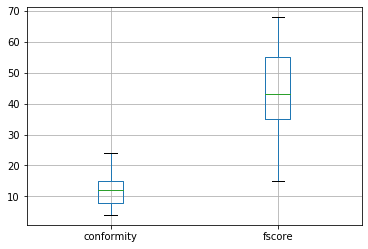

In [42]:
moorePd.boxplot() #outlier없이 잘 분포되어있다.

#### fcategory별 fscore 그래프
먼저 fcategory별 fscore를 계산해서 그래프를 그려야 한다.

In [43]:
_fscore = moorePd.groupby('fcategory')['fscore'].mean()

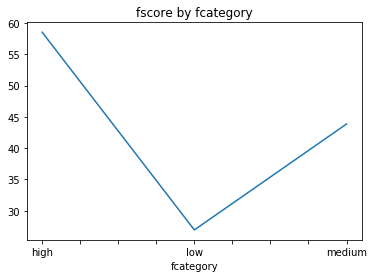

In [44]:
_fscore.plot(x="fcategory", y=_fscore,  title="fscore by fcategory")